# Guide to Model Stacking in Practice
*Interactive [article](https://gormanalysis.com/guide-to-model-stacking-i-e-meta-ensembling/)*


### Introduction

Stacking (also called meta ensembling) is a model ensembling technique used to combine information from multiple predictive models to generate a new model. Often times the stacked model (also called 2nd-level model) will outperform each of the individual models due its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. For this reason, stacking is most effective when the base models are significantly different. Here I provide a simple example and guide on how stacking is most often implemented in practice.


## Classify Dart Throwers

### Motivation

Suppose four people throw a combined 187 darts at a board. For 150 of those we get to see who threw each dart and where it landed. For the rest, we only get to see where the dart landed. Our task is to guess who threw each of the unlabelled darts based on their landing spot.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv("_Data/train.csv", )
test = pd.read_csv("_Data/test.csv")

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['Competitor'].unique())
train.loc[:, 'Competitor_id'] = le.transform(train['Competitor'])
test.loc[:, 'Competitor_id'] = le.transform(test['Competitor'])

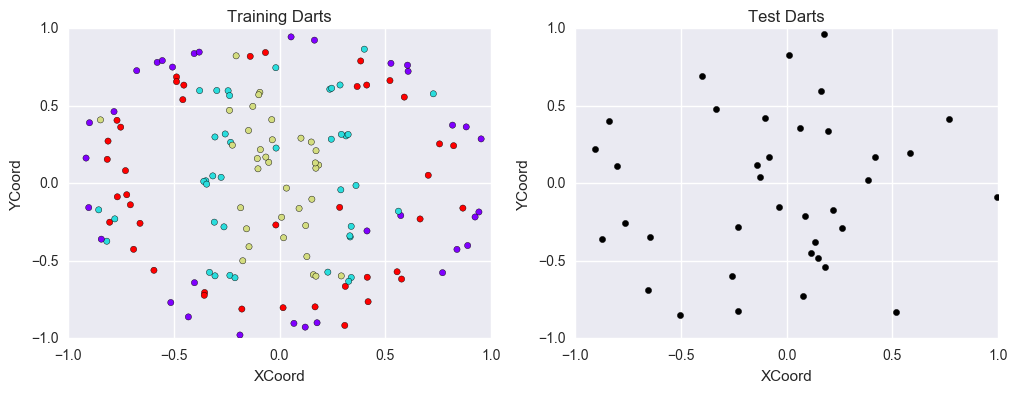

In [3]:
def plot_data(df, title='', colors='k'):
    plt.title(title)
    plt.scatter(df['XCoord'], df['YCoord'], c=colors, cmap=plt.cm.rainbow)
    plt.xlabel("XCoord"); plt.ylabel("YCoord")
    plt.xlim((-1, 1)); plt.ylim((-1, 1))
    
    
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_data(train, "Training Darts", train['Competitor_id'])
plt.subplot(122)
plot_data(test, "Test Darts", 'k')

## K-Nearest Neighbors (Base Model1)

Let’s make a sad attempt at solving this classification problem using a K-Nearest Neighbors model. In order to select the best value for K, we’ll use 5-fold Cross-Validation combined with Grid Search where K=(1, 2, … 30). In pseudo code


1. Partition the training data into five equal size folds. Call these test folds
2. For K = 1, 2, … 10<br>
    2.1 For each test fold<br>
    2.1.1 Combine the other four folds to be used as a training fold<br>
    2.1.2 Fit a K-Nearest Neighbors model on the training fold (using the current value of K)<br>
    2.1.3 Make predictions on the test fold and measure the resulting accuracy rate of the predictions<br>
    2.2 Calculate the average accuracy rate from the five test fold predictions<br>
3. Keep the K value with the best average CV accuracy rate

With our fictitious data we find K=1 to have the best CV performance (67% accuracy). Using K=1, we now train a model on the entire training dataset and make predictions on the test dataset. Ultimately this will give us about 70% classification accuracy.

In [4]:
train.loc[:, 'DistFromCenter'] = np.sqrt(train['XCoord']**2 + train['YCoord']**2)
test.loc[:, 'DistFromCenter'] = np.sqrt(test['XCoord']**2 + test['YCoord']**2)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = train[['XCoord', 'YCoord']]
y = train['Competitor_id']

n_max_neighbors = 30
n_folds = 5

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, n_max_neighbors)}
clf = GridSearchCV(knn, params, cv=n_folds, scoring='accuracy', n_jobs=2)
_ = clf.fit(X, y)

Best parameters set found on development set: 
 {'n_neighbors': 1} 

Grid scores on development set: 

0.653 (+/-0.204) for {'n_neighbors': 1}
0.567 (+/-0.106) for {'n_neighbors': 2}
0.587 (+/-0.106) for {'n_neighbors': 3}
0.507 (+/-0.087) for {'n_neighbors': 4}
0.493 (+/-0.054) for {'n_neighbors': 5}


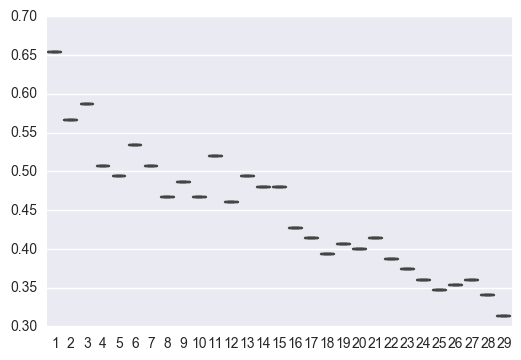

In [6]:
print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))
print("Grid scores on development set: \n")
ll = n_max_neighbors // 6
means = clf.cv_results_['mean_test_score'][:ll]
stds = clf.cv_results_['std_test_score'][:ll]
param_res = clf.cv_results_['params'][:ll]
for mean, std, params in zip(means, stds, param_res):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
plt.figure()
sns.boxplot(x="param_n_neighbors", y="mean_test_score", data=clf.cv_results_)

In [7]:
from sklearn.metrics import accuracy_score

X_train = train[['XCoord', 'YCoord']]
y_train = train['Competitor_id']
X_test = test[['XCoord', 'YCoord']]
y_test = test['Competitor_id']

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Classsification accuracy on test data : %f" % accuracy)

Classsification accuracy on test data : 0.702703


## Support Vector Machine (Base Model2)

Now let’s make another sad attempt at solving the problem using a Support Vector Machine. Additionally, we’ll add a feature `DistFromCenter` that measures the distance each point lies from the center of the board to help make the data linearly separable. We get two hyper parameters to tune:

### Type
1. L2-regularized L2-loss support vector classification (dual)<br>
2. L2-regularized L2-loss support vector classification (primal)<br> 
3. L2-regularized L1-loss support vector classification (dual)<br>
4. Support vector classification by Crammer and Singer<br>
5. L1-regularized L2-loss support vector classification<br>


### Cost
Inverse of the regularization constant

The grid of parameter combinations we’ll test is the cartesian product of the 5 listed SVM types with cost values of (.01, .1, 1, 10, 100, 1000, 2000). That is


| Type | Cost |
|---|---|
| 1 | 0.01 |
| 1 | 0.1 |
| 1 | 1 |
| ... | ... |
| 5 | 100 |
| 5 | 1000 |
| 5 | 2000 |

Using the same CV + Grid Search approach we used for our K-Nearest Neighbors model, here we find the best hyper-parameters to be type = 4 with cost = 1000. Again, we use these parameters to train a model on the full training dataset and make predictions on the test dataset. This’ll give us about 61% CV classification accuracy and 78% classification accuracy on the test dataset.

In [8]:
from sklearn.svm import LinearSVC

X = train[['XCoord', 'YCoord', 'DistFromCenter']]
y = train['Competitor_id']

n_folds = 5

svc = LinearSVC()
c_arr = [0.01, 0.1, 1, 100, 1000, 2000]
params = [
    # Type 1 : L2, L2, dual
    {"loss": ['squared_hinge'], "penalty": ['l2'], "dual": [True], 'C': c_arr}, 
    # Type 2 : L2, L2, primal
    {"loss": ['squared_hinge'], "penalty": ['l2'], "dual": [False], 'C': c_arr}, 
    # Type 3 : L2, L1, dual
    {"loss": ['hinge'], "penalty": ['l2'], "dual": [True], 'C': c_arr}, 
    # Type 4 : Crammer and Singer
    {'multi_class': ['crammer_singer'], 'C': c_arr}, 
    # Type 5 : L1, L2, primal
    {"loss": ['squared_hinge'], "penalty": ['l1'], "dual": [False], 'C': c_arr}, 
]

clf = GridSearchCV(svc, params, scoring='accuracy', cv=n_folds, n_jobs=2)
_ = clf.fit(X, y)

In [9]:
print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))

print("Grid scores on development set: \n")
means = clf.cv_results_['mean_test_score'][:5]
stds = clf.cv_results_['std_test_score'][:5]
param_res = clf.cv_results_['params'][:5]
for mean, std, params in zip(means, stds, param_res):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
X_train = train[['XCoord', 'YCoord', 'DistFromCenter']]
y_train = train['Competitor_id']
X_test = test[['XCoord', 'YCoord', 'DistFromCenter']]
y_test = test['Competitor_id']

svc = LinearSVC(multi_class='crammer_singer', C=1000)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n Classsification accuracy on test data : %f" % accuracy)

Best parameters set found on development set: 
 {'multi_class': 'crammer_singer', 'C': 2000} 

Grid scores on development set: 

0.380 (+/-0.133) for {'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'C': 0.01}
0.460 (+/-0.112) for {'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'C': 0.1}
0.520 (+/-0.168) for {'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'C': 1}
0.580 (+/-0.158) for {'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'C': 100}
0.473 (+/-0.061) for {'loss': 'squared_hinge', 'penalty': 'l2', 'dual': True, 'C': 1000}

 Classsification accuracy on test data : 0.837838


## Stacking (Meta Ensembling)

Let’s take a look at the regions of the board each model would classify as Bob, Sue, Mark, or Kate.

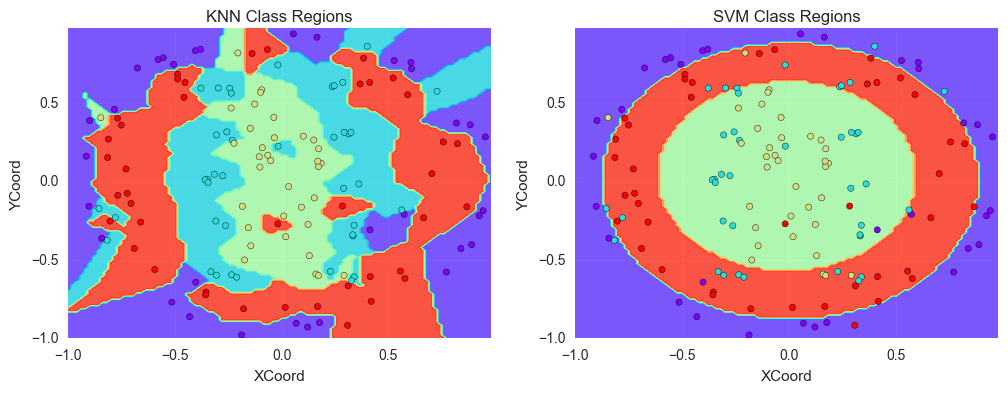

In [11]:
# create a mesh to plot in
x_min, x_max = -1, 1
y_min, y_max = -1, 1
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
dd = np.sqrt(xx**2 + yy**2)

def plot_results(xx, yy, Z, df):
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.8)
    plt.xlabel('XCoord')
    plt.ylabel('YCoord')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(df['XCoord'], df['YCoord'], c=df['Competitor_id'], cmap=plt.cm.rainbow)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('KNN Class Regions')
# Plot KNN
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plot_results(xx, yy, Z, train)

plt.subplot(122)
plt.title('SVM Class Regions')
# Plot SVN
Z = svc.predict(np.c_[xx.ravel(), yy.ravel(), dd.ravel()])
Z = Z.reshape(xx.shape)
plot_results(xx, yy, Z, train)

Unsurprisingly, the SVM does a good job at classifying Bob’s throws and Sue’s throws but does poorly at separating Kate’s throws and Mark’s throws. The opposite appears to be true for the K-nearest neighbors model. HINT: Stacking these models will probably be fruitful.

There are a few schools of thought on how to actually implement stacking. Here’s my personal favorite applied to our example problem:

**1. Partition the training data into five test folds**

**2. Create a dataset called `train_meta` with the same row Ids and fold Ids as the training dataset, with empty columns M1 and M2. Similarly create a dataset called `test_meta` with the same row Ids as the test dataset and empty columns M1 and M2**

In [12]:
train_meta = train.copy()
train_meta['M1'] = np.nan
train_meta['M2'] = np.nan
train_meta[['ID', 'XCoord', 'YCoord', 'M1', 'M2', 'Competitor']].head()

,ID,XCoord,YCoord,M1,M2,Competitor
0,111,0.943354,-0.184819,NaN,NaN,Bob
1,92,0.121557,-0.927656,NaN,NaN,Bob
2,20,0.818485,0.375437,NaN,NaN,Bob
3,75,0.867462,-0.159851,NaN,NaN,Sue
4,10,-0.817321,-0.373419,NaN,NaN,Kate


In [13]:
test_meta = test.copy()
test_meta['M1'] = np.nan
test_meta['M2'] = np.nan
test_meta[['ID', 'XCoord', 'YCoord', 'M1', 'M2', 'Competitor']].head()

,ID,XCoord,YCoord,M1,M2,Competitor
0,6,0.064729,0.356983,NaN,NaN,Mark
1,12,-0.766731,-0.255876,NaN,NaN,Sue
2,22,0.182282,-0.540976,NaN,NaN,Mark
3,34,-0.908910,0.223945,NaN,NaN,Bob
4,47,0.992230,-0.085550,NaN,NaN,Bob


3. For each test fold `{Fold1, Fold2, … Fold5}`

3.1 Combine the other four folds to be used as a training fold

3.2 For each base model

    M1: K-Nearest Neighbors (k = 1)
    M2: Support Vector Machine (type = 4, cost = 1000)

In [ ]:
from sklearn.cross_validation import StratifiedKFold

